<a href="https://colab.research.google.com/github/changsin/FSDL/blob/main/plate_recognizer/notebooks/kaggle_data_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Test Kaggle license plate dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/changsin/FSDL

Cloning into 'FSDL'...
remote: Enumerating objects: 825, done.
remote: Counting objects: 100% (57/57), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 825 (delta 36), reused 43 (delta 26), pack-reused 768
Receiving objects: 100% (825/825), 105.40 MiB | 16.03 MiB/s, done.
Resolving deltas: 100% (528/528), done.


In [3]:
%load_ext autoreload
%autoreload 2

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from importlib.util import find_spec
if find_spec("plate_recognizer") is None:
    import sys
    sys.path.append('..')

In [ ]:
# TODO: creates some incompatibility problems so commenting out for now
# !pip install pytorch_lightning==1.1.4

In [4]:
from FSDL.plate_recognizer.data.kaggle_data import KaggleData
from FSDL.plate_recognizer.data.cluster import Cluster

kaggle_data = KaggleData()
kaggle_data.prepare_data()
kaggle_data.cluster_data(unique=False)
kaggle_data.X.shape

##### log path is /content #####
##### log path is /content #####
##### log path is /content #####


(433, 224, 224, 3)

In [20]:
kaggle_data.partition_on_clusters()

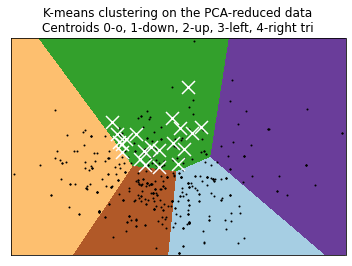

In [21]:
import FSDL.plate_recognizer.utils.plots as plots

plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, kaggle_data.test_idx[1])

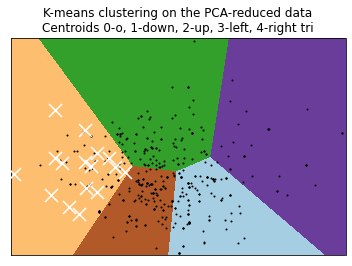

In [22]:
plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, kaggle_data.test_idx[2])

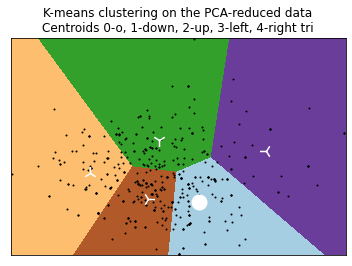

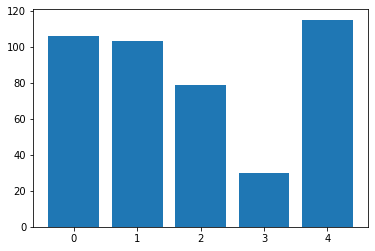

In [24]:
import FSDL.plate_recognizer.utils.plots as plots

K = 5

plots.plot_pca_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca)
plots.plot_cluster_histogram(kaggle_data.X_pca_clusters, K)

2021-06-21 05:16:38,083 - FSDL.plate_recognizer.data.cluster - INFO - cluster.py:104 - Found 135 duplicates


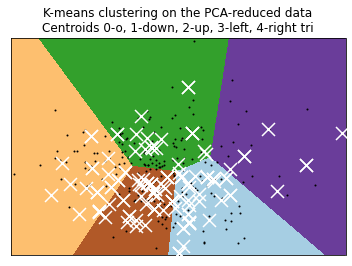

In [25]:
to_remove_idx = Cluster.find_duplicates(kaggle_data.X_pca_reduced)
plots.plot_data_in_clusters(kaggle_data.X_pca_reduced, kaggle_data.kmeans_pca, to_remove_idx)

# Remove duplicate data points

In [26]:
kaggle_data_uniq = KaggleData()
kaggle_data_uniq.prepare_data()
kaggle_data_uniq.cluster_data(K=5, unique=True)

2021-06-21 05:17:23,038 - FSDL.plate_recognizer.data.cluster - INFO - cluster.py:104 - Found 135 duplicates
2021-06-21 05:17:23,039 - FSDL.plate_recognizer.data.kaggle_data - INFO - kaggle_data.py:88 - Removing duplicates 135
2021-06-21 05:17:23,040 - FSDL.plate_recognizer.data.kaggle_data - INFO - kaggle_data.py:92 - Using only 298


In [6]:
def calc_variances(X_pca_reduced):
  # Calculate distances of all points
  distances = cdist(X_pca_reduced, X_pca_reduced)

  # Find duplicates (very similar images)
  # dupes = np.array([np.where(distances[id] < 1) for id in range(distances.shape[0])]).reshape(-1)
  dupes = [np.array(np.where(distances[id] < 1)).reshape(-1).tolist() \
          for id in range(distances.shape[0])]

  to_remove = set()
  for d in dupes:
      if len(d) > 1:
          for id in range(1, len(d)):
              to_remove.add(d[id])
  logger.info("Found {} duplicates".format(len(to_remove)))
  return to_remove

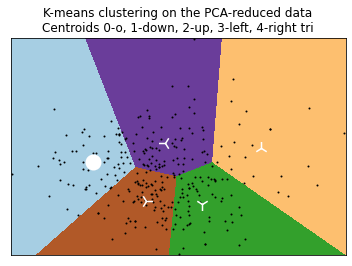

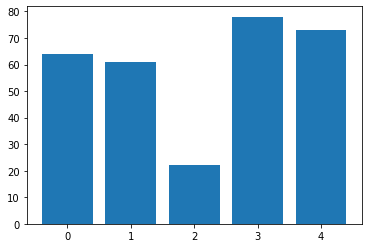

In [27]:
plots.plot_pca_clusters(kaggle_data_uniq.X_pca_reduced, kaggle_data_uniq.kmeans_pca)
plots.plot_cluster_histogram(kaggle_data_uniq.X_pca_clusters, K)

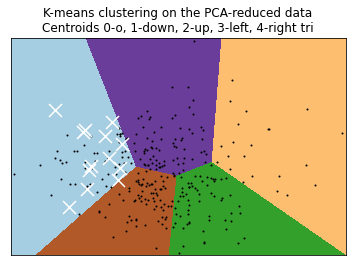

In [29]:
kaggle_data_uniq.partition_on_clusters()

plots.plot_data_in_clusters(kaggle_data_uniq.X_pca_reduced,
                            kaggle_data_uniq.kmeans_pca,
                            kaggle_data_uniq.test_idx[0])

# Weights and Biases

In [30]:
!pip install wandb -qqq
import wandb
wandb.login()

     |████████████████████████████████| 1.8MB 15.9MB/s 
     |████████████████████████████████| 102kB 11.4MB/s 
     |████████████████████████████████| 174kB 46.2MB/s 
     |████████████████████████████████| 133kB 51.4MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

# Train

## Train with the full dataset

In [148]:
from FSDL.plate_recognizer.data.base_data_module import DataType
from FSDL.plate_recognizer.models.plate_model import PlateModel
from FSDL.plate_recognizer.training.trainer import Trainer

plate_model = PlateModel()

X_train, Y_train = kaggle_data.get_data(data_type=DataType.Train)
model_cnn = plate_model.create_model(Y_train.shape[0])

trainer = Trainer(model_cnn)
model_cnn = trainer.train(kaggle_data, epochs=50)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_3 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_10 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_11 (Dense)             (None, 64)                8256      
_________________________________________________________________
module_wrapper_3 (ModuleWrap (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
20/20 [==============================] - 4s 116ms/step - loss: 0.0535 - accuracy: 0.4989 - val_loss: 0.0194 - val_accuracy: 0.5000


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0153 - accuracy: 0.7175 - val_loss: 0.0083 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0112 - accuracy: 0.6938 - val_loss: 0.0108 - val_accuracy: 0.5263


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0068 - accuracy: 0.7759 - val_loss: 0.0066 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0059 - accuracy: 0.8416 - val_loss: 0.0087 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0057 - accuracy: 0.7601 - val_loss: 0.0077 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/50
20/20 [==============================] - 1s 28ms/step - loss: 0.0051 - accuracy: 0.8494 - val_loss: 0.0055 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0044 - accuracy: 0.8096 - val_loss: 0.0062 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0047 - accuracy: 0.8112 - val_loss: 0.0080 - val_accuracy: 0.5263


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0038 - accuracy: 0.8039 - val_loss: 0.0056 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0040 - accuracy: 0.8061 - val_loss: 0.0059 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0035 - accuracy: 0.8537 - val_loss: 0.0056 - val_accuracy: 0.8158


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0031 - accuracy: 0.8663 - val_loss: 0.0052 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0032 - accuracy: 0.8647 - val_loss: 0.0065 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0028 - accuracy: 0.8820 - val_loss: 0.0051 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0030 - accuracy: 0.8543 - val_loss: 0.0058 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0037 - accuracy: 0.8886 - val_loss: 0.0053 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0025 - accuracy: 0.9116 - val_loss: 0.0059 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0026 - accuracy: 0.9023 - val_loss: 0.0053 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0024 - accuracy: 0.9293 - val_loss: 0.0064 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 21/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0026 - accuracy: 0.8745 - val_loss: 0.0051 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 22/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0023 - accuracy: 0.9073 - val_loss: 0.0054 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 23/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0022 - accuracy: 0.8788 - val_loss: 0.0052 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 24/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0023 - accuracy: 0.8818 - val_loss: 0.0061 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 25/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0025 - accuracy: 0.8922 - val_loss: 0.0058 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 26/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0025 - accuracy: 0.8622 - val_loss: 0.0053 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 27/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0025 - accuracy: 0.8525 - val_loss: 0.0057 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 28/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0022 - accuracy: 0.8882 - val_loss: 0.0055 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 29/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0018 - accuracy: 0.9152 - val_loss: 0.0048 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 30/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.9134 - val_loss: 0.0063 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 31/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0021 - accuracy: 0.9073 - val_loss: 0.0056 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 32/50
20/20 [==============================] - 1s 26ms/step - loss: 0.0019 - accuracy: 0.8867 - val_loss: 0.0066 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 33/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0024 - accuracy: 0.9096 - val_loss: 0.0055 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 34/50
20/20 [==============================] - 1s 28ms/step - loss: 0.0017 - accuracy: 0.9335 - val_loss: 0.0053 - val_accuracy: 0.6053


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 35/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0022 - accuracy: 0.8963 - val_loss: 0.0051 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 36/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0019 - accuracy: 0.8916 - val_loss: 0.0049 - val_accuracy: 0.6316


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 37/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0019 - accuracy: 0.8795 - val_loss: 0.0048 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 38/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.8978 - val_loss: 0.0052 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 39/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0017 - accuracy: 0.9083 - val_loss: 0.0056 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 40/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0017 - accuracy: 0.9111 - val_loss: 0.0049 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 41/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0015 - accuracy: 0.9396 - val_loss: 0.0053 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 42/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.9183 - val_loss: 0.0046 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 43/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.9297 - val_loss: 0.0049 - val_accuracy: 0.6842


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 44/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0015 - accuracy: 0.9234 - val_loss: 0.0049 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 45/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.9552 - val_loss: 0.0051 - val_accuracy: 0.7632


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 46/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0015 - accuracy: 0.9073 - val_loss: 0.0046 - val_accuracy: 0.7895


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 47/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0017 - accuracy: 0.9208 - val_loss: 0.0055 - val_accuracy: 0.7105


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 48/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.8845 - val_loss: 0.0040 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 49/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0016 - accuracy: 0.9233 - val_loss: 0.0045 - val_accuracy: 0.7368


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 50/50
20/20 [==============================] - 1s 27ms/step - loss: 0.0014 - accuracy: 0.9330 - val_loss: 0.0048 - val_accuracy: 0.6579


wandb: WARNING No validation_data set, pass a generator to the callback.


2021-06-21 07:14:49,608 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:37 - Score : 79.55%
100/100 [==============================] - 1s 4ms/step - loss: 0.0084 - accuracy: 0.7614
2021-06-21 07:14:50,845 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:41 - Test results 
 Loss: 0.00838374998420477
 Accuracy: 0.7613636255264282


## Train with unique data points

With the duplicate data points removed, the model train much faster and better accuracy 78% -> 92%

In [35]:
from FSDL.plate_recognizer.data.base_data_module import DataType
from FSDL.plate_recognizer.models.plate_model import PlateModel
from FSDL.plate_recognizer.training.trainer import Trainer

plate_model_uniq = PlateModel()

X_train_uniq, Y_train_uniq = kaggle_data_uniq.get_data(data_type=DataType.Train)
model_cnn_uniq = plate_model_uniq.create_model(Y_train_uniq.shape[0])

trainer_uniq = Trainer(model_cnn_uniq, name="Trained on unique data points")
model_cnn_uniq = trainer_uniq.train(kaggle_data_uniq, epochs=50)

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               3211392   
_________________________________________________________________
dense_7 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
module_wrapper_2 (ModuleWrap (None, 4)                 516       
Total params: 17,951,364
Trainable params: 3,236,676
Non-trainable params: 14,714,688
__________________________________

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2191: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Epoch 1/50
14/14 [==============================] - 33s 185ms/step - loss: 0.0708 - accuracy: 0.4752 - val_loss: 0.0265 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 2/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0248 - accuracy: 0.6685 - val_loss: 0.0272 - val_accuracy: 0.4231


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 3/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0173 - accuracy: 0.6308 - val_loss: 0.0170 - val_accuracy: 0.6154


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 4/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0138 - accuracy: 0.7943 - val_loss: 0.0121 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 5/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0098 - accuracy: 0.7539 - val_loss: 0.0108 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 6/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0090 - accuracy: 0.7196 - val_loss: 0.0070 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 7/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0089 - accuracy: 0.8348 - val_loss: 0.0081 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 8/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0061 - accuracy: 0.6849 - val_loss: 0.0118 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 9/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0073 - accuracy: 0.8151 - val_loss: 0.0113 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 10/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0067 - accuracy: 0.8324 - val_loss: 0.0087 - val_accuracy: 0.6154


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 11/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0071 - accuracy: 0.8142 - val_loss: 0.0080 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 12/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0050 - accuracy: 0.7673 - val_loss: 0.0080 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 13/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0046 - accuracy: 0.8406 - val_loss: 0.0095 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 14/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0049 - accuracy: 0.8950 - val_loss: 0.0086 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 15/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0057 - accuracy: 0.8203 - val_loss: 0.0077 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 16/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0053 - accuracy: 0.8900 - val_loss: 0.0085 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 17/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0045 - accuracy: 0.8076 - val_loss: 0.0054 - val_accuracy: 0.6154


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 18/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0040 - accuracy: 0.8693 - val_loss: 0.0093 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 19/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.8125 - val_loss: 0.0062 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 20/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0034 - accuracy: 0.9138 - val_loss: 0.0075 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 21/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0036 - accuracy: 0.8661 - val_loss: 0.0065 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 22/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0032 - accuracy: 0.8350 - val_loss: 0.0070 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 23/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - accuracy: 0.8680 - val_loss: 0.0052 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 24/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0026 - accuracy: 0.9062 - val_loss: 0.0070 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 25/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - accuracy: 0.8958 - val_loss: 0.0052 - val_accuracy: 0.8462


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 26/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.8878 - val_loss: 0.0070 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 27/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0029 - accuracy: 0.8797 - val_loss: 0.0074 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 28/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0025 - accuracy: 0.9272 - val_loss: 0.0063 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 29/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0028 - accuracy: 0.9147 - val_loss: 0.0059 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 30/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0033 - accuracy: 0.8802 - val_loss: 0.0055 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 31/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0024 - accuracy: 0.9133 - val_loss: 0.0059 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 32/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0029 - accuracy: 0.8870 - val_loss: 0.0059 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 33/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0025 - accuracy: 0.8359 - val_loss: 0.0064 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 34/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0024 - accuracy: 0.8763 - val_loss: 0.0053 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 35/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0020 - accuracy: 0.9095 - val_loss: 0.0048 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 36/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0023 - accuracy: 0.9286 - val_loss: 0.0060 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 37/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0022 - accuracy: 0.8702 - val_loss: 0.0057 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 38/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0023 - accuracy: 0.8802 - val_loss: 0.0048 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 39/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.9202 - val_loss: 0.0063 - val_accuracy: 0.6538


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 40/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0021 - accuracy: 0.9155 - val_loss: 0.0046 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 41/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.8856 - val_loss: 0.0072 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 42/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9123 - val_loss: 0.0055 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 43/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0018 - accuracy: 0.9270 - val_loss: 0.0063 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 44/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9212 - val_loss: 0.0051 - val_accuracy: 0.6923


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 45/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0018 - accuracy: 0.8708 - val_loss: 0.0061 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 46/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0019 - accuracy: 0.8660 - val_loss: 0.0049 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 47/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0020 - accuracy: 0.9122 - val_loss: 0.0051 - val_accuracy: 0.8077


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 48/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0021 - accuracy: 0.9255 - val_loss: 0.0053 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 49/50
14/14 [==============================] - 0s 27ms/step - loss: 0.0017 - accuracy: 0.8867 - val_loss: 0.0041 - val_accuracy: 0.7692


wandb: WARNING No validation_data set, pass a generator to the callback.


Epoch 50/50
14/14 [==============================] - 0s 26ms/step - loss: 0.0016 - accuracy: 0.9456 - val_loss: 0.0053 - val_accuracy: 0.7308


wandb: WARNING No validation_data set, pass a generator to the callback.


2021-06-21 05:38:15,132 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:37 - Score : 69.35%
100/100 [==============================] - 1s 3ms/step - loss: 0.0104 - accuracy: 0.6613
2021-06-21 05:38:16,452 - FSDL.plate_recognizer.training.trainer - INFO - trainer.py:41 - Test results 
 Loss: 0.01038196962326765
 Accuracy: 0.6612903475761414


# Predictions

Predict on both models


In [258]:
import FSDL.plate_recognizer.training.predictor as predictor

stats = predictor.predict_on_models(kaggle_data, range(K),
                                    [model_cnn, model_cnn_uniq],
                                    iterations=50, iou_threshold=0.5)

1/1 [==============================] - 0s 49ms/step - loss: 0.0025 - accuracy: 0.7727
2021-06-21 09:14:47,358 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 0 mAP: 0.38 std: 0.02 acc: 0.77
1/1 [==============================] - 0s 49ms/step - loss: 0.0118 - accuracy: 0.7619
2021-06-21 09:14:50,334 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 1 mAP: 0.24 std: 0.02 acc: 0.76
1/1 [==============================] - 0s 37ms/step - loss: 0.0188 - accuracy: 0.7500
2021-06-21 09:14:52,509 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 2 mAP: 0.22 std: 0.02 acc: 0.75
1/1 [==============================] - 0s 26ms/step - loss: 0.0055 - accuracy: 0.8333
2021-06-21 09:14:53,763 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 3 mAP: 0.17 std: 0.02 acc: 0.83
1/1 [==============================] - 0s 49ms/step - loss: 0.0035 - accuracy: 0.8696
2021-06-21 09:14:56,872 - FSDL.plate_recognizer.training.predictor

In [259]:
stats_uniq = predictor.predict_on_models(kaggle_data_uniq, range(K),
                                         [model_cnn, model_cnn_uniq],
                                         iterations=100, iou_threshold=0.7)

1/1 [==============================] - 0s 37ms/step - loss: 0.0018 - accuracy: 1.0000
2021-06-21 09:15:20,463 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 0 mAP: 0.38 std: 0.02 acc: 1.00
1/1 [==============================] - 0s 36ms/step - loss: 0.0031 - accuracy: 0.8462
2021-06-21 09:15:24,334 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 1 mAP: 0.62 std: 0.02 acc: 0.85
1/1 [==============================] - 1s 502ms/step - loss: 0.0062 - accuracy: 0.8000
2021-06-21 09:15:27,500 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 2 mAP: 0.40 std: 0.02 acc: 0.80
1/1 [==============================] - 0s 36ms/step - loss: 0.0016 - accuracy: 0.7500
2021-06-21 09:15:31,801 - FSDL.plate_recognizer.training.predictor - INFO - predictor.py:66 - 3 mAP: 0.40 std: 0.02 acc: 0.75
1/1 [==============================] - 1s 1s/step - loss: 0.0031 - accuracy: 0.6667
2021-06-21 09:15:37,608 - FSDL.plate_recognizer.training.predictor 

Compare the results. Standard deviations first. It does not show any statistical differences.

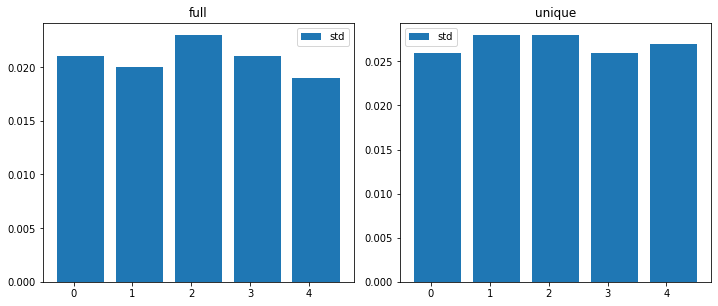

In [260]:
import FSDL.plate_recognizer.utils.plots as plots

titles = ["full", "unique"]
plots.plot_stats(stats, ["std"], titles)

mAP is showing a little bit worse result for the unique dataset. Perhaps it is because the dataset is too small.

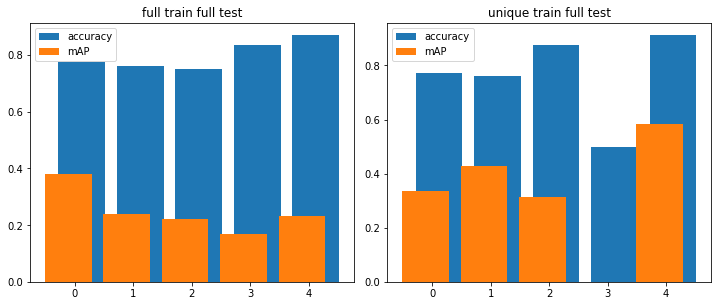

In [274]:
titles = ["full train full test", "unique train full test"]
plots.plot_stats(stats, ["accuracy", "mAP"], titles)

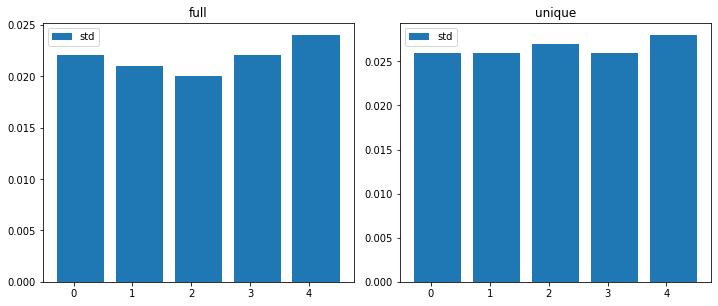

In [262]:
titles = ["full", "unique"]
plots.plot_stats(stats_uniq, ["std"], titles)

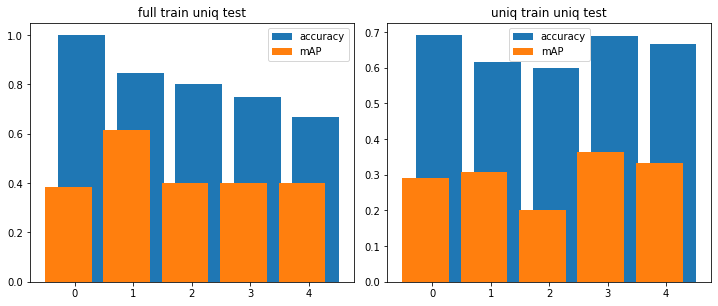

In [273]:
titles = ["full train uniq test", "uniq train uniq test"]
plots.plot_stats(stats_uniq, ["accuracy", "mAP"], titles)

1/1 [==============================] - 0s 37ms/step - loss: 0.0099 - accuracy: 0.7692


tensor(0.3483)

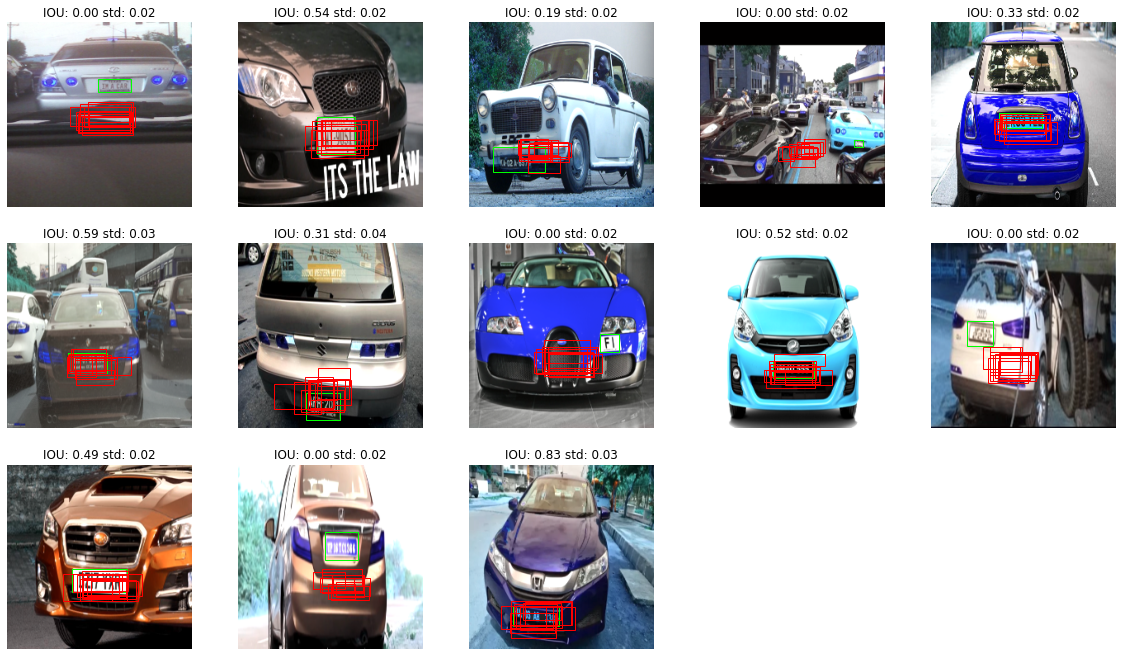

In [266]:
X_test_uniq, Y_test_uniq = kaggle_data_uniq.get_data(data_type=DataType.Test, cluster_id=0)

y_preds_uniq, m_ap_uniq, mstd_uniq, accuracy_uniq = \
  predictor.predict_on_cluster(model_cnn_uniq, X_test_uniq, Y_test_uniq, iterations=10)
plots.plot_predictions(X_test_uniq, Y_test_uniq, y_preds_uniq)
m_ap_uniq

1/1 [==============================] - 0s 51ms/step - loss: 0.0030 - accuracy: 0.7273


tensor(0.3718)

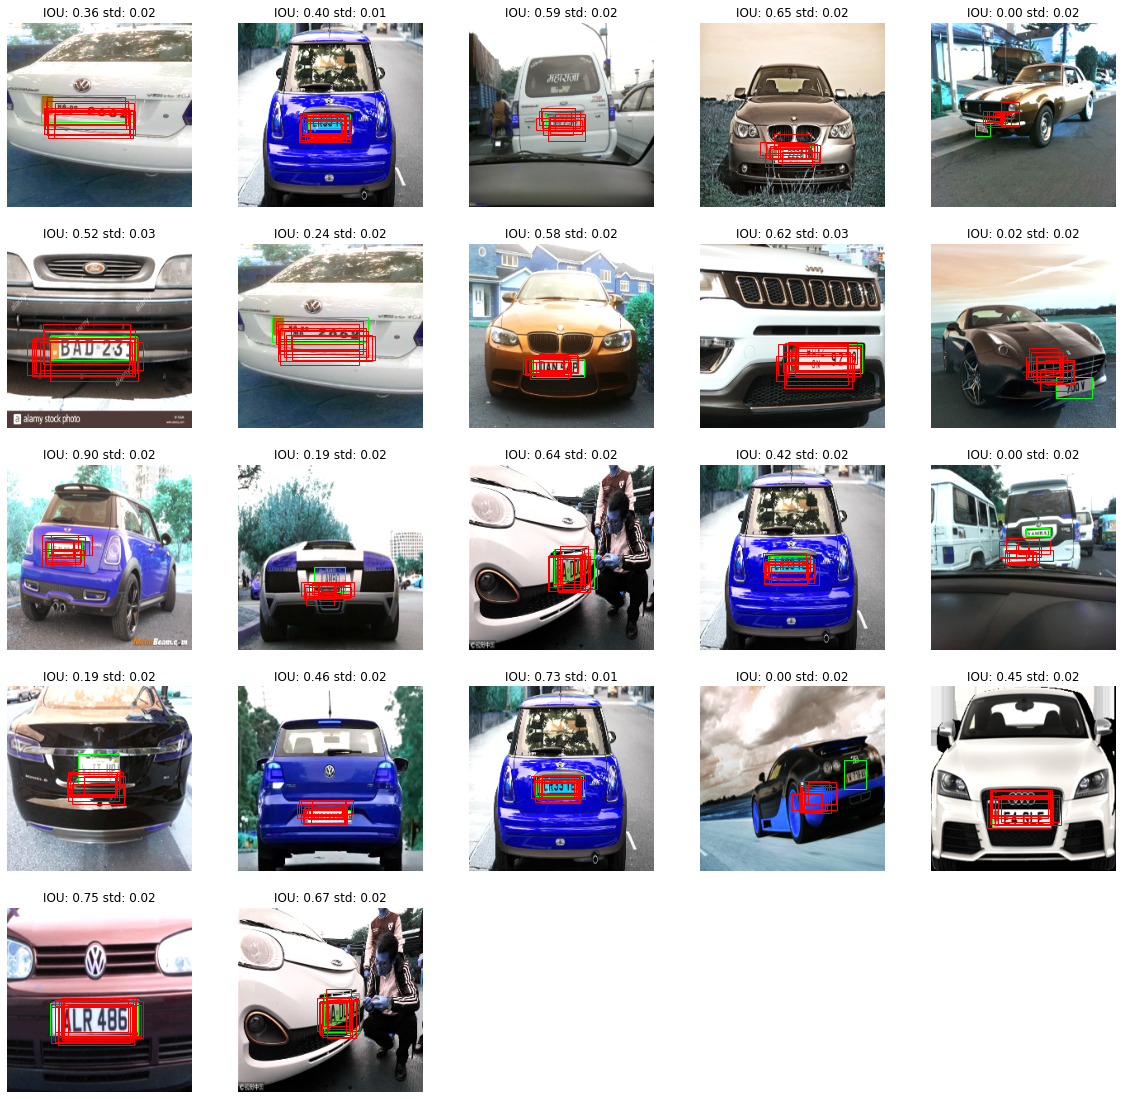

In [268]:
X_test, Y_test = kaggle_data.get_data(data_type=DataType.Test, cluster_id=0)

y_preds, m_ap, mstd, accuracy = \
  predictor.predict_on_cluster(model_cnn, X_test, Y_test, iterations=10)
plots.plot_predictions(X_test, Y_test, y_preds)
m_ap

1/1 [==============================] - 0s 38ms/step - loss: 0.0017 - accuracy: 1.0000


tensor(0.3846)

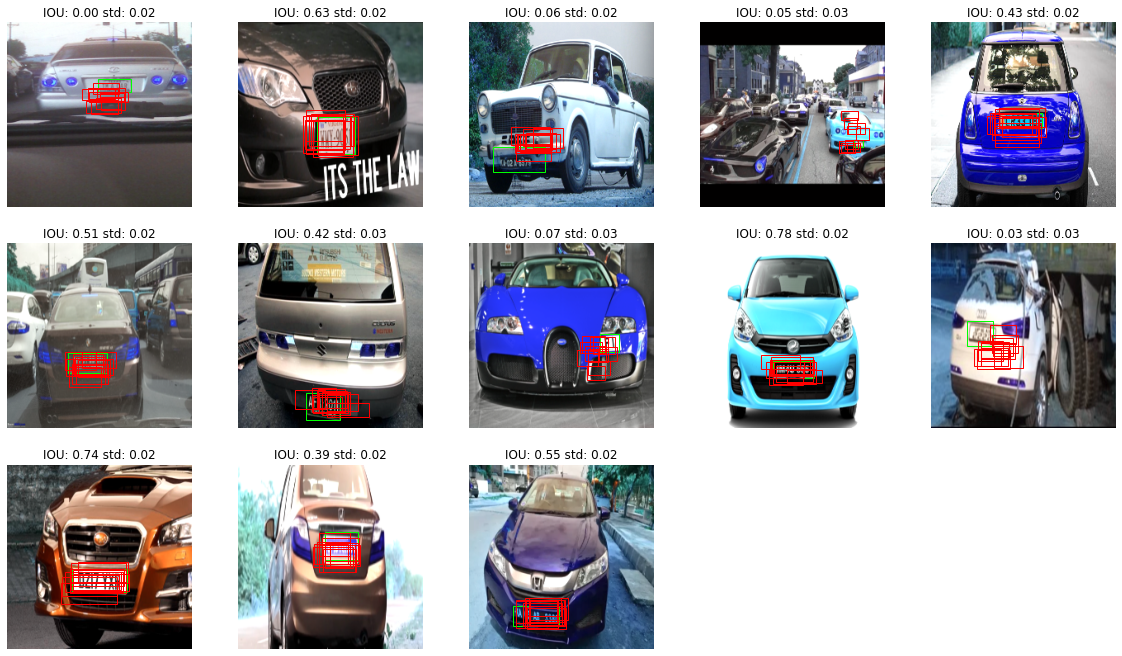

In [270]:
y_preds, m_ap, mstd, accuracy = \
  predictor.predict_on_cluster(model_cnn, X_test_uniq, Y_test_uniq, iterations=10)
plots.plot_predictions(X_test_uniq, Y_test_uniq, y_preds)
m_ap